In [ ]:
import copy
import datetime
import pickle
from pathlib import Path

import glob2
import numpy as np
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from scipy.stats import t as student
from associator import locate
from utils.data_reading.catalogs.ISC import ISC_file
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.bathymetry.bathymetry_grid import BathymetryGrid
from utils.physics.sound.sound_model import HomogeneousSoundModel
from utils.physics.sound.sound_velocity_grid import MonthlySoundVelocityGridOptimized
from utils.data_reading.sound_data.sound_file_manager import NpyFilesManager

from utils.transformations.features_extractor import STFTFeaturesExtractor
import torch
from torchvision.transforms import Resize
from utils.training.embedder import Embedder, EmbedderSegmenter


/home/plerolland/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"
sound_model_h = HomogeneousSoundModel()
sound_model_g = MonthlySoundVelocityGridOptimized(
    [f"../../data/sound_model/min-velocities_month-{i:02d}.nc" for i in range(1, 13)], interpolate=True)
#bathy_model = BathymetryGrid.create_from_NetCDF("../../data/geo/GEBCO_2023_sub_ice_topo.nc", lat_bounds=[-75, 35],
#                                                lon_bounds=[-20, 180])
year = 2012
stations_c = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated().starts_before(datetime.datetime(year+1,1,1)).ends_after(datetime.datetime(year,1,1))
#isc_file = f"/home/plerolland/Bureau/catalogs/ISC/eqk_isc_{year}.txt"
#isc = ISC_file(isc_file)
MIN_P = 0.4
MIN_P_MATES = 0.2
NB = 3
TOLERANCE = datetime.timedelta(seconds=20)
ALLOWED_DELTA = 30  # for ISC clustering
TIME_DELTA_SEARCH = datetime.timedelta(seconds=5*86400)
RES_FILE = f"../../data/detections/{year}/matchups_clusters_loc.csv"

TIME_RES = 0.5 # duration, in s, of a sample in the associator results
HALF_FOCUS_SIZE = 32  # window to compare for associator
MAX_SHIFT = 32  # max allowed shift resulting from associator

embedder_checkpoint = "../../data/model_saves/embedder/torch_save_segmenter"
model_embedder = torch.load(embedder_checkpoint, map_location='cpu')

In [3]:
to_read = glob2.glob(f"../../data/detections/{year}/*.p")
detections = {}

for file in tqdm(to_read):
    info = file.split("_")[-1][:-2].split("-")
    name, year = "-".join(info[:-1]), int(info[-1])
    station = stations_c.by_starting_year(year).by_names(name)[0]
    detections[station] = []
    with open(file, "rb") as f:
        while True:
            try:
                detections[station].append(pickle.load(f))
            except EOFError:
                break
    detections[station] = np.array(detections[station], dtype=np.object_)
    detections[station] = detections[station][np.argsort(detections[station][:,0])]

  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
year = 2012
station = list(detections.keys())[0]
embedding_manager = NpyFilesManager(f"../../data/detections/{year}/embedding_{year}_{station.name}-{station.date_start.year}")
manager = station.get_manager()
stft_computer = STFTFeaturesExtractor(manager, vmin=60, vmax=140)

[datetime.datetime(2012, 12, 9, 15, 21, 56, 743590) 0.954]
(16, 239)


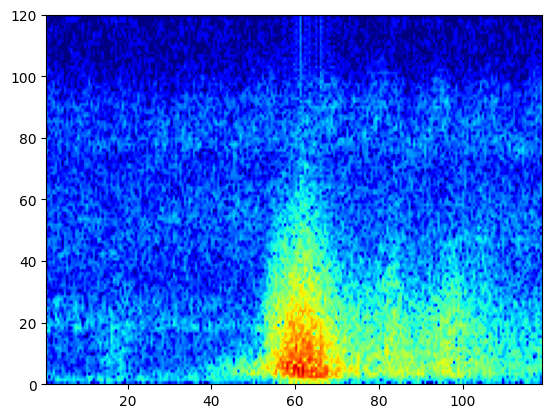

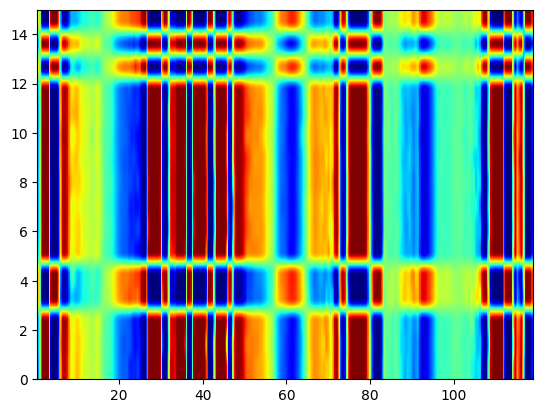

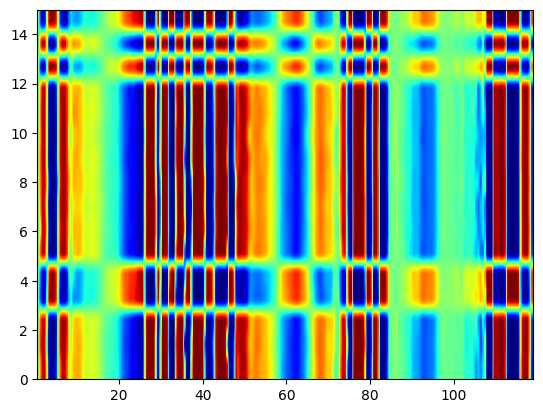

In [5]:
dets = detections[station]
dets = dets[np.argsort(dets[:,1])[::-1]]
det = dets[1]

print(dets[0])
delta = datetime.timedelta(seconds=60)

data = manager.getSegment(det[0]-delta, det[0]+delta)
embedding = embedding_manager.getSegment(det[0]-delta, det[0]+delta)

print(embedding.shape)
f, t, spectro = stft_computer._get_features(data)
plt.imshow(spectro, aspect="auto", extent=(t[0],t[-1],f[-1],f[0]), cmap="jet", vmin=0, vmax=255)
plt.figure()
plt.imshow(embedding, aspect="auto", extent=(t[0],t[-1],0, 15), cmap="jet", vmin=-1, vmax=1)

data = 2*(spectro[np.newaxis, :, :] / 255 - 0.5).astype(np.float32)
data = Resize((64, data.shape[-1]))(torch.from_numpy(data))
with torch.no_grad():
    res = model_embedder(data)
plt.figure()
plt.imshow(res, aspect="auto", extent=(t[0],t[-1],0, 15), cmap="jet", vmin=-1, vmax=1)

In [6]:
from huge_dataset_project.PickLoader import PickFile
from huge_dataset_project.InputLoader import InputFile
from scipy.signal import find_peaks


def get_embedding(embedding_managers, station, date):
    m = embedding_managers[station]
    return m.getSegment(date-datetime.timedelta(seconds=TIME_RES*(MAX_SHIFT+HALF_FOCUS_SIZE+1)), date+datetime.timedelta(seconds=TIME_RES*(MAX_SHIFT+HALF_FOCUS_SIZE+1)))

def get_closest_detection(detection_dates, date):
    idx = np.searchsorted(detection_dates, date)
    if idx > 0 and np.abs(detection_dates[idx-1] - date) < np.abs(detection_dates[idx] - date):
        idx = idx - 1
    elif idx < len(detection_dates)-1 and np.abs(detection_dates[idx+1] - date) < np.abs(detection_dates[idx] - date):
        idx = idx + 1
    return idx

def find_shift(anchor_embedding, detection_embedding, max_diff=0.4):
    center = embedding_anchor.shape[1]//2
    anchor_embedding = anchor_embedding[:, center-HALF_FOCUS_SIZE:center+HALF_FOCUS_SIZE]
    
    detection_embedding = [detection_embedding[:, center+i-HALF_FOCUS_SIZE:center+i+HALF_FOCUS_SIZE] for i in range(-MAX_SHIFT, MAX_SHIFT+1)]
    differences = np.sqrt(np.sum((np.array(detection_embedding)-anchor_embedding[np.newaxis,:,:])**2, axis=(1,2))) / np.sqrt(HALF_FOCUS_SIZE*2*16*2)

    peaks, _ = find_peaks(-differences, height=-max_diff)
    peaks_s = np.round((peaks - len(differences)//2)*TIME_RES).astype(np.int32)
    if len(peaks_s)>0:
        idx = np.argmin(np.abs(peaks_s))
        peak, height = peaks_s[idx], differences[peaks[idx]]
    else:
        peak, height = 0, None
    
    return datetime.timedelta(seconds=int(peak)), height, differences

picks = PickFile("/home/plerolland/Documents/Seismic_catalogs/Indian/2012/2012_SEIR_12Dec_29S.pick")
picks = PickFile("/home/plerolland/Documents/Seismic_catalogs/Indian/2012/2012_SPA_04Apr_37S.pick")
np.random.seed(0)
np.random.shuffle(picks.picks)
input = InputFile("/home/plerolland/Documents/Seismic_catalogs/Indian/2012/2012_SEIR_Network.input")
input.hydrophone_letters = list(input.hydrophone_letters)

In [8]:
expected_locs = {}
locs = {}
peaks = {}

embedding_managers = {s : NpyFilesManager(f"../../data/detections_long/{year}/embedding_{year}_{s.name}-{s.date_start.year}") for s in stations_c.by_names(input.hydrophone_names)}

for pick in tqdm(picks.picks[:]):
    expected_det_stations = [input.hydrophone_names[input.hydrophone_letters.index(h)] for h in pick.hydrophones if h in input.hydrophone_letters]
    expected_det_stations = [stations_c.by_date(pick.detection_times[i]).by_names(expected_det_stations[i])[0] for i in range(len(expected_det_stations))]
   # expected_det_dates =  {expected_det_stations[i] : pick.detection_times[i] for i in range(len(expected_det_stations))}
    expected_det_dates =  {s : pick.est_source_time + datetime.timedelta(seconds=sound_model_g.get_sound_travel_time(pick.est_source_pos,s.get_pos(), date=pick.est_source_time)) for s in expected_det_stations}
    observed_dets = {}
    
    deltas = []
    for s in expected_det_stations:
        idx = get_closest_detection(detections[s][:,0], expected_det_dates[s])
        delta = np.abs(detections[s][idx,0] - expected_det_dates[s]).total_seconds()
        if delta < 30:
            observed_dets[s] = detections[s][idx]
            deltas.append(delta)
            
    stations = list(observed_dets.keys())
    if len(stations) < 4:
        continue  # undetected
    
    # we keep the closest detection and try to shift the others, to match at best this one
    anchor = stations[np.argmin(deltas)]
    embedding_anchor = get_embedding(embedding_managers, anchor, observed_dets[anchor][0])
    for s in stations:
        if s == anchor:
            continue
        embedding = get_embedding(embedding_managers, s, observed_dets[s][0])
        shift, peak_height, diff = find_shift(embedding_anchor, embedding)
        peaks.setdefault(pick.est_source_time, {})[s] = shift, peak_height, diff
        observed_dets[s][0] += shift
        
    det_pos = [s.get_pos() for s in observed_dets.keys()]
    det_times = np.array(list(observed_dets.values()))[:,0]
    try:
        r = sound_model_g.localize_common_source(det_pos, det_times)
    except:
        r = None
    locs[pick.est_source_time] = r
    expected_locs[pick.est_source_time] = [pick.est_source_time] + list(pick.est_source_pos)

  0%|          | 0/1626 [00:00<?, ?it/s]

In [12]:
diffs, costs = [], []
for i in locs.keys():
    if type(locs[i]) == list or locs[i] is None:
        continue
    diff = np.sqrt(np.sum((np.array(expected_locs[i][1:]) - np.array(locs[i].x[1:]))**2))
    if locs[i].cost > 1000:
        continue
    diffs.append(diff)
    costs.append(locs[i].cost)
    
    print(f"{costs[-1]:6.2f} - {diffs[-1]:5.2f} - {i} - {[h for s, h, d in peaks[i].values()]}")
    

print(len(costs))
print(np.mean(diffs))

np.save("expected_locs_SPA.npy", expected_locs)
np.save("locs_SPA.npy", locs)
np.save("peaks_SPA.npy", peaks)

573.95 -  0.25 - 2012-10-16 14:21:02.200000 - [None, None, None]
 21.30 -  0.31 - 2012-04-11 10:40:16 - [0.1434, 0.349, 0.1407, 0.341, 0.139]
 30.23 -  0.04 - 2012-03-20 09:24:47.400000 - [0.3337, 0.326, 0.2695, None]
517.81 -  0.15 - 2012-04-11 17:29:34.800000 - [None, None, 0.3616, None]
 68.87 -  1.32 - 2012-03-16 14:16:01.100000 - [None, None, None, None]
127.81 -  0.12 - 2012-04-11 10:56:52.100000 - [0.3884, 0.2544, 0.2258, 0.3633]
802.25 -  0.12 - 2012-10-23 11:03:42.400000 - [None, None, None, None]
  3.70 -  0.47 - 2012-10-24 05:13:21.200000 - [None, None, None]
195.27 -  0.27 - 2012-10-16 00:20:15.600000 - [None, 0.399, 0.3425, None, None, None]
244.77 -  0.02 - 2012-04-13 15:32:53.400000 - [None, None, None, None, None]
123.89 -  0.17 - 2012-04-16 23:42:17.800000 - [0.2463, None, 0.1387, 0.293, 0.361, 0.3909, 0.2964]
223.93 -  0.14 - 2012-03-12 14:02:55.800000 - [None, None, None, None]
 58.43 -  0.14 - 2012-10-10 23:13:35.800000 - [0.36, 0.3958, None]
218.30 -  0.46 - 2012-0

In [108]:
expected_locs = {}
locs = {}
peaks = {}

embedding_managers = {s : NpyFilesManager(f"../../data/detections_long/{year}/embedding_{year}_{s.name}-{s.date_start.year}") for s in stations_c.by_names(input.hydrophone_names)}

for pick in tqdm(picks.picks[:]):
    expected_det_stations = [input.hydrophone_names[input.hydrophone_letters.index(h)] for h in pick.hydrophones]
    expected_det_stations = [stations_c.by_date(pick.detection_times[i]).by_names(expected_det_stations[i])[0] for i in range(len(expected_det_stations))]
   # expected_det_dates =  {expected_det_stations[i] : pick.detection_times[i] for i in range(len(expected_det_stations))}
    expected_det_dates =  {s : pick.est_source_time + datetime.timedelta(seconds=sound_model_g.get_sound_travel_time(pick.est_source_pos,s.get_pos(), date=pick.est_source_time)) for s in expected_det_stations}
    observed_dets = {}
    
    deltas = []
    heights = []
    for s in expected_det_stations:
        idx = get_closest_detection(detections[s][:,0], expected_det_dates[s])
        delta = np.abs(detections[s][idx,0] - expected_det_dates[s]).total_seconds()
        if delta < 10:
            observed_dets[s] = detections[s][idx]
            deltas.append(delta)
            heights.append(detections[s][idx][1])
    stations = list(observed_dets.keys())
    # we keep the closest detection and try to detect others'
    #anchor = stations[np.argmin(deltas)]
    anchor = stations[np.argmax(heights)]
    observed_dets = {anchor: observed_dets[anchor]}
    embedding_anchor = get_embedding(embedding_managers, anchor, observed_dets[anchor][0])
    
    for s in expected_det_stations:
        if s == anchor:
            continue
        embedding = get_embedding(embedding_managers, s, expected_det_dates[s])
        shift, peak_height, differences = find_shift(embedding_anchor, embedding)
        peaks.setdefault(pick.est_source_time, {})[s] = shift, peak_height, differences
        observed_dets[s] = [expected_det_dates[s]+shift, None]
    
    stations = list(observed_dets.keys())
    if len(stations) < 4:
        continue  # undetected
        
    det_pos = [s.get_pos() for s in observed_dets.keys()]
    det_times = np.array(list(observed_dets.values()))[:,0]
    try:
        r = sound_model_g.localize_common_source(det_pos, det_times)
    except:
        r = None
    locs[pick.est_source_time] = r
    expected_locs[pick.est_source_time] = [pick.est_source_time] + list(pick.est_source_pos)

  0%|          | 0/76 [00:00<?, ?it/s]

283.51 -  0.06 - 2012-12-12 04:20:19.700000 - [('NEAMS', 0.0, '0.27'), ('SWAMS', -1.0, '0.33'), ('MAD', 0.0, '0.28'), ('WKER2', -2.0, '0.31'), ('WKER1', -2.0, '0.36'), ('WKER3', 0.0, '0.30'), ('RAMA', 0.0, '0.34')]
  6.63 -  0.11 - 2012-12-12 02:23:55 - [('NEAMS', -10.0, '0.33'), ('MAD', -6.0, '0.33'), ('WKER2', 0.0, '0.26'), ('WKER1', 0.0, '0.36'), ('NCRO3', 0.0, '0.29')]
158.49 -  0.06 - 2012-12-12 02:37:07.700000 - [('NEAMS', 0.0, '-1.00'), ('WKER2', 0.0, '-1.00'), ('WKER1', -14.0, '0.40'), ('WKER3', 0.0, '-1.00'), ('NCRO3', -2.0, '0.38'), ('RAMA', 0.0, '-1.00')]
161.68 -  0.05 - 2012-12-12 02:32:11.500000 - [('NEAMS', -10.0, '0.38'), ('SWAMS', 0.0, '-1.00'), ('MAD', 0.0, '-1.00'), ('WKER2', -4.0, '0.36'), ('WKER3', -11.0, '0.33')]
 60.83 -  0.14 - 2012-12-12 13:42:02.300000 - [('SWAMS', -2.0, '0.36'), ('MAD', -1.0, '0.37'), ('WKER2', 4.0, '0.30'), ('WKER1', -2.0, '0.35'), ('WKER3', 0.0, '-1.00')]
 64.99 -  0.04 - 2012-12-12 04:40:54.700000 - [('NEAMS', 0.0, '0.22'), ('SWAMS', -2.0,

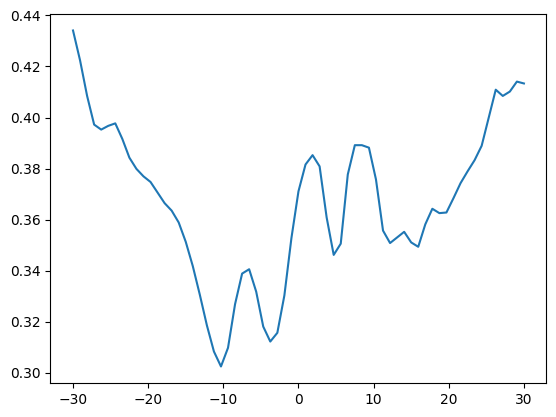

In [23]:
diffs, costs = [], []
for i in locs.keys():
    if type(locs[i]) == list or locs[i] is None:
        continue
    diff = np.sqrt(np.sum((np.array(expected_locs[i][1:]) - np.array(locs[i].x[1:]))**2))
    if locs[i].cost > 1000:
        continue
    diffs.append(diff)
    costs.append(locs[i].cost)
    
    print(f'{costs[-1]:6.2f} - {diffs[-1]:5.2f} - {i} - {[(s.name, shift.total_seconds(), f"{h or -1:.2f}") for s, (shift, h, _) in peaks[i].items()]}')
    
data = list(peaks[datetime.datetime(2012,12,12,4,20,19,700000)].values())[3][2]
zoom = 0
plt.plot(np.linspace(-30+zoom,30-zoom,len(data)-4*zoom), data[2*zoom:(-2*zoom if zoom > 0 else None)])
plt.xlim()

print(len(costs))
print(np.mean(diffs))
#20.15 -  0.02 - 2012-12-12 03:47:52.100000 - [('NEAMS', -1.0, '0.40'), ('SWAMS', -2.0, '0.09'), ('MAD', -4.0, '0.38'), ('WKER1', 0.0, '0.09'), ('WKER3', -5.0, '0.08'), ('NCRO3', 0.0, '0.10'), ('RAMA', 4.0, '0.49'), ('H01W1', 1.0, '0.47')]
# 272.86 -  0.06 - 2012-12-12 03:47:52.100000 - [('NEAMS', 14.0, '0.18'), ('SWAMS', -2.0, '0.09'), ('MAD', 12.0, '0.09'), ('WKER1', 0.0, '0.09'), ('WKER3', -5.0, '0.08'), ('NCRO3', 0.0, '0.10'), ('RAMA', -7.0, '0.13'), ('H01W1', 12.0, '0.19')]

In [7]:
diffsT, costsT, nbT = [], [], []

embedding_managers = {s : NpyFilesManager(f"../../data/detections_long/{year}/embedding_{year}_{s.name}-{s.date_start.year}") for s in stations_c.by_names(input.hydrophone_names)}

max_shifts = list(range(8,129,8))
half_focus_sizes = list(range(4,133,8))

for MAX_SHIFT in tqdm(max_shifts):
    for HALF_FOCUS_SIZE in tqdm(half_focus_sizes, leave=False):
        def get_embedding(embedding_managers, station, date):
            m = embedding_managers[station]
            return m.getSegment(date-datetime.timedelta(seconds=TIME_RES*(MAX_SHIFT+HALF_FOCUS_SIZE+1)), date+datetime.timedelta(seconds=TIME_RES*(MAX_SHIFT+HALF_FOCUS_SIZE+1)))
        
        def get_closest_detection(detection_dates, date):
            idx = np.searchsorted(detection_dates, date)
            if idx > 0 and np.abs(detection_dates[idx-1] - date) < np.abs(detection_dates[idx] - date):
                idx = idx - 1
            elif idx < len(detection_dates)-1 and np.abs(detection_dates[idx+1] - date) < np.abs(detection_dates[idx] - date):
                idx = idx + 1
            return idx
        
        def find_shift(anchor_embedding, detection_embedding, max_diff=0.3):
            center = embedding_anchor.shape[1]//2
            anchor_embedding = anchor_embedding[:, center-HALF_FOCUS_SIZE:center+HALF_FOCUS_SIZE]
            
            detection_embedding = [detection_embedding[:, center+i-HALF_FOCUS_SIZE:center+i+HALF_FOCUS_SIZE] for i in range(-MAX_SHIFT, MAX_SHIFT+1)]
            differences = np.sqrt(np.sum((np.array(detection_embedding)-anchor_embedding[np.newaxis,:,:])**2, axis=(1,2))) / np.sqrt(HALF_FOCUS_SIZE*2*16*2)
        
            peaks, _ = find_peaks(-differences, height=-max_diff)
            peaks_s = np.round((peaks - len(differences)//2)*TIME_RES).astype(np.int32)
            if len(peaks_s)>0:
                idx = np.argmin(np.abs(peaks_s))
                peak, height = peaks_s[idx], differences[peaks[idx]]
            else:
                peak, height = 0, None
            
            return datetime.timedelta(seconds=int(peak)), height, differences
        
        expected_locs = {}
        locs = {}
        peaks = {}
        
        
        
        for pick in tqdm(picks.picks[:], leave=False):
            expected_det_stations = [input.hydrophone_names[input.hydrophone_letters.index(h)] for h in pick.hydrophones]
            expected_det_stations = [stations_c.by_date(pick.detection_times[i]).by_names(expected_det_stations[i])[0] for i in range(len(expected_det_stations))]
           # expected_det_dates =  {expected_det_stations[i] : pick.detection_times[i] for i in range(len(expected_det_stations))}
            expected_det_dates =  {s : pick.est_source_time + datetime.timedelta(seconds=sound_model_g.get_sound_travel_time(pick.est_source_pos,s.get_pos(), date=pick.est_source_time)) for s in expected_det_stations}
            observed_dets = {}
            
            deltas = []
            heights = []
            for s in expected_det_stations:
                idx = get_closest_detection(detections[s][:,0], expected_det_dates[s])
                delta = np.abs(detections[s][idx,0] - expected_det_dates[s]).total_seconds()
                if delta < 10:
                    observed_dets[s] = detections[s][idx]
                    deltas.append(delta)
                    heights.append(detections[s][idx][1])
            stations = list(observed_dets.keys())
            # we keep the closest detection and try to detect others'
            #anchor = stations[np.argmin(deltas)]
            anchor = stations[np.argmax(heights)]
            observed_dets = {anchor: observed_dets[anchor]}
            embedding_anchor = get_embedding(embedding_managers, anchor, observed_dets[anchor][0])
            
            for s in expected_det_stations:
                if s == anchor:
                    continue
                try:
                    embedding = get_embedding(embedding_managers, s, expected_det_dates[s])
                except:
                    continue
                shift, peak_height, differences = find_shift(embedding_anchor, embedding)
                if not peak_height:
                    continue
                peaks.setdefault(pick.est_source_time, {})[s] = shift, peak_height, differences
                observed_dets[s] = [expected_det_dates[s]+shift, peak_height]
            
            stations = list(observed_dets.keys())
            if len(stations) < 4:
                continue  # undetected
                
            det_pos = [s.get_pos() for s in observed_dets.keys()]
            det_times = np.array(list(observed_dets.values()))[:,0]
            try:
                r = sound_model_g.localize_common_source(det_pos, det_times)
            except:
                r = None
            locs[pick.est_source_time] = r
            expected_locs[pick.est_source_time] = [pick.est_source_time] + list(pick.est_source_pos)
            
        diffs, costs = {}, {}
        for i in locs.keys():
            if type(locs[i]) == list or locs[i] is None:
                continue
            diff = np.sqrt(np.sum((np.array(expected_locs[i][1:]) - np.array(locs[i].x[1:]))**2))
            if locs[i].cost > 1000:
                continue
            diffs[i] = diff
            costs[i] = locs[i].cost
        
        costsT.append(costs)
        diffsT.append(diffs)
        nbT.append(len(list(costs.keys())))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [10]:
np.save("costsT.npy", costsT)
np.save("diffsT.npy", diffsT)
np.save("nbT.npy", nbT)

res = [[-1 for _ in half_focus_sizes] for _ in max_shifts]
for i in range(len(max_shifts)):
    for j in range(len(half_focus_sizes)):
        idx = i*len(half_focus_sizes)+j
        
        cost, diff, nb = costsT[idx], diffsT[idx], nbT[idx]
        cost = np.max(list(cost.values()))
        diff = np.mean(list(diff.values()))
        
        res[i][j] = cost
        
plt.imshow(res, extent=(max_shifts[0],max_shifts[-1], half_focus_sizes[0], half_focus_sizes[-1]))
plt.xlabel("max shifts")
plt.ylabel("half_focus_sizes")
plt.colorbar()
#plt.savefig("76_picks_experiment_diffs.png")

ValueError: zero-size array to reduction operation maximum which has no identity

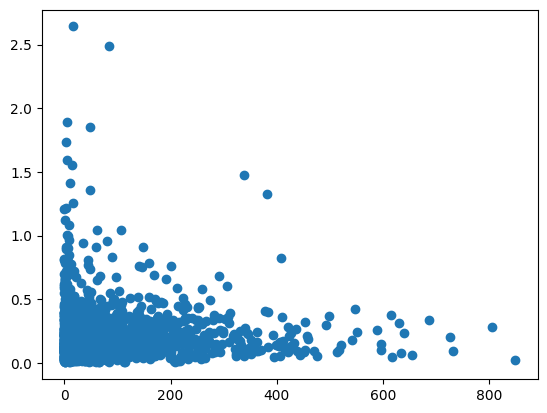

In [109]:
from matplotlib import pyplot as plt

plt.scatter(costs, diffs)

In [126]:
diffs, costs = {}, {}
for i in locs.keys():
    if type(locs[i]) == list or locs[i] is None:
        continue
    diff = np.sqrt(np.sum((np.array(expected_locs[i][1:]) - np.array(locs[i].x[1:]))**2))
    if locs[i].cost > 1000:
        continue
    diffs[i] = diff
    costs[i] = locs[i].cost
    
    print(f"{costs[i]:6.2f} - {diffs[i]:5.2f} - {i}")

print(len(costs))

272.17 -  0.17 - 2018-10-06 10:40:41.400000
276.63 -  0.21 - 2018-10-24 11:14:36.700000
  1.22 -  0.07 - 2018-10-03 18:19:58
 19.59 -  0.14 - 2018-10-01 18:10:58.700000
 77.46 -  0.26 - 2018-10-01 01:41:35.500000
222.13 -  0.15 - 2018-10-01 16:13:10.100000
  8.19 -  0.04 - 2018-09-29 10:34:33.700000
100.21 -  0.21 - 2018-10-08 18:48:25.900000
 68.23 -  0.07 - 2018-10-01 14:33:00.600000
 75.33 -  0.07 - 2018-10-01 02:45:39
331.08 -  0.25 - 2018-10-05 07:55:45.800000
 24.24 -  0.32 - 2018-10-02 18:51:26.800000
  0.00 -  0.03 - 2018-09-28 08:37:16.300000
 17.84 -  0.53 - 2018-09-27 17:25:58.700000
113.25 -  0.12 - 2018-10-01 07:42:58
 13.51 -  0.03 - 2018-10-03 16:52:21.900000
  8.70 -  0.11 - 2018-10-05 04:28:55.800000
 35.44 -  0.32 - 2018-10-13 15:37:10.500000
156.20 -  0.25 - 2018-10-03 09:45:08.700000
  3.73 -  0.58 - 2018-10-11 18:40:30.400000
  7.11 -  0.09 - 2018-10-02 00:40:39.100000
 15.58 -  0.09 - 2018-10-04 14:27:04.100000
  0.15 -  0.03 - 2018-10-20 06:44:29.800000
 20.16 - 

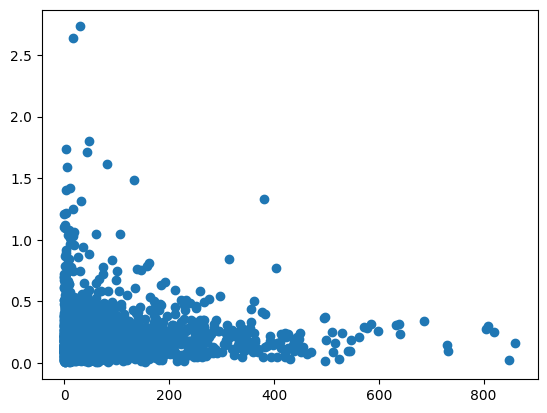

In [127]:
from matplotlib import pyplot as plt

plt.scatter(costs.values(), diffs.values())

In [122]:
np.save("costs.npy", locs)
res = ""
for loc in locs.values():
    if loc.cost<100:
        res += str(loc.x[1])+","+str(loc.x[2])+"\n"
with open("relocated.csv", "w") as f:
    f.write(res)

In [136]:
d = {i : diff for i, diff in diffs.items() if costs[i] < 50}

worst = list(d.keys())[np.argmax(list(d.values()))]
print(worst, diffs[worst], costs[worst])
print(expected_locs[worst], locs[worst].x)

2018-10-14 16:18:55.800000 2.732425239361186 30.551576122966225
[datetime.datetime(2018, 10, 14, 16, 18, 55, 800000), -26.740047, 67.925438] [-743.55261366  -24.54474451   66.29854075]


In [135]:
for pick in picks.picks:
    if pick.est_source_time != worst:
        continue
    expected_det_stations = [input.hydrophone_names[input.hydrophone_letters.index(h)] for h in pick.hydrophones]
    print(expected_det_stations, pick.detection_times)
    if "SWAMS" in expected_det_stations:
        expected_det_stations[expected_det_stations.index("SWAMS")] += "-bot"
    expected_det_stations = [stations_c.by_date(pick.detection_times[i]).by_names(expected_det_stations[i])[0] for i in range(len(expected_det_stations))]
   # expected_det_dates =  {expected_det_stations[i] : pick.detection_times[i] for i in range(len(expected_det_stations))}
    expected_det_dates =  {s : pick.est_source_time + datetime.timedelta(seconds=sound_model_g.get_sound_travel_time(pick.est_source_pos,s.get_pos(), date=pick.est_source_time)) for s in expected_det_stations}
    observed_dets = {}
    
    for s in expected_det_stations:
        idx = get_closest_detection(detections[s][:,0], expected_det_dates[s])
        if np.abs(detections[s][idx,0] - expected_det_dates[s]).total_seconds() < 30:
            observed_dets[s] = detections[s][idx]
            
    stations = list(observed_dets.keys())
    if len(stations) < 4:
        continue  # undetected
    
    det_times = {s: observed_dets[s][0] for s in stations}
    
    embedding_anchor = observed_dets[stations[0]][-1]
    for s in stations[1:]:
        shift = find_shift(embedding_anchor, observed_dets[s][-1])
        print(shift)
        det_times[s] += shift
        
    det_pos = [s.get_pos() for s in det_times.keys()]
    det_times = list(det_times.values())
    
    print([s.name for s in stations], det_pos, det_times)
    try:
        r = sound_model_g.localize_common_source(det_pos, det_times)
    except:
        r = None

['SSEIR', 'MADW', 'NEAMS', 'SWAMS', 'ELAN'] [datetime.datetime(2018, 10, 14, 16, 28, 2, 275000), datetime.datetime(2018, 10, 14, 16, 34, 24, 867000), datetime.datetime(2018, 10, 14, 16, 36, 49, 50000), datetime.datetime(2018, 10, 14, 16, 40, 24, 207000), datetime.datetime(2018, 10, 14, 16, 56, 41, 125000)]
-1 day, 23:59:52
0:00:01
0:00:01
['SSEIR', 'NEAMS', 'SWAMS-bot', 'ELAN'] [[-33.5175, 70.8657], [-31.5758, 83.2423], [-42.9513, 74.5975], [-56.4602, 62.976]] [datetime.datetime(2018, 10, 14, 16, 28, 13, 760684), datetime.datetime(2018, 10, 14, 16, 36, 34, 427350), datetime.datetime(2018, 10, 14, 16, 40, 22, 957265), datetime.datetime(2018, 10, 14, 16, 56, 10, 299145)]
